# Optimization of the spatial profile

Idea:
 - The goal is to extract a flux, reproject it on the detector and determine a correction on the spatial profile using this projection
 - For a given pixel, we don't know to which order the correction corresponds, so we assume that the correction is proportional to the previous estimate of the spatial profile of each order.
 - We also assume that the correction we want to bring is a fraction of the estimate of the error. This is know as a fixed point iteration method

Definitions:
 - $P_i$: Real spatial profile at order $i$
 - $P^{(j)}_i$: $j$ th estimate of the spatial profile at order $i$
 - $\epsilon^{(j)}_i$ estimate of the error of $P^{(j)}_i$ compared to $P_i$, so that $\epsilon^{(j)}_i = P_i - P^{(j)}_i$
 - $E^{(n)}$: Relative error of the rebuilt detector (compared to the data). Given by the equation: (detector - rebuilt) / rebuilt
 - $\alpha$: scale factor

Description: <br>
If we assume that the error $\epsilon^{(j)}_i$ at a given pixel is proportional to the spatial profile estimate of each order ($P^{(j)}_i$), we can demonstrate that
\begin{equation}
\epsilon^{(j)}_1 = \frac{P^{(j)}_1}{P^{(j)}_2} \epsilon^{(j)}_2 ,
\end{equation}
assuming we have 2 orders.

Then, if we assume that a pixel (or the detector) can be modeled as

\begin{equation}
M^{(j)} = (P^{(j)}_1 + \epsilon^{(j)}_1) \int_1 (...) d\lambda \, + \,\, (P^{(j)}_2 + \epsilon^{(j)}_2) \int_2 (...) d\lambda  ,
\end{equation}
we can conclude that
\begin{equation}
\epsilon^{(j)}_i = P^{(j)}_i E^{(j)}
\end{equation}

Finally, the next estimate of $P_i$ will be given by $P^{(j+1)}_i = P^{(j)}_i + \alpha \epsilon^{(j)}_i = P^{(j)}_i + \alpha P^{(j)}_i E^{(j)}$.

Convergence:
- This has the form $g(P_i) = P_i + \alpha f(P_i)$ and we are looking to find $P_i^*$ such that $g(P_i^*) = P_i^*$. That is the definition of a **fixed point**.
- A typical stopping criterion is to require that
\begin{equation}
    \frac{|P_i^{(j+1)} - P_i^{(j)}|}{max(P_i^{(j)}, \xi)} < tol_i
\end{equation}
where $\xi$ ensures that the criterion does not diverge if $P_i$ is close to zero. $tol_i$ is the relative tolerance of a given pixel. The relative error map could be used.



## Imports

In [1]:
# Import standard packages.
import numpy as np
from astropy.io import fits

# Imports from the extraction.
from extract.overlap import TrpzOverlap
from extract.throughput import ThroughputSOSS
from extract.convolution import WebbKer

# Imports for plots
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm  # For displaying of FITS images.
# TODO astropy has some nice functions for colorbars scaling of astronomical data, might be worth looking into.

### Matplotlib defaults

In [2]:
%matplotlib inline

In [3]:
plt.rc('figure', figsize=(13,8)) 
plt.rc('font', size=16)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=2)

## Load simulation

In [8]:
# Import custom function to read toy simulation
from sys import path  # TODO all import should be at the top. 
# Answer: this is temporary since we should have better simulations eventually
#         and my format was very custom. That's why I let this whole section
#         in a separate bloc.
path.append("Fake_data")
from simu_utils import load_simu  # TODO can this function be moved to utils?
# Answer: same as previous comment: very custom format. Should be changed.
# Load a simulation
simu = load_simu("../../Simulations/phoenix_teff_09000_scale_1.0e+02_vsini_5_gaussker.fits")
data = simu["data"]

## Read some ref files

In [11]:
from extract.convolution import fwhm2sigma, gaussians
from scipy.interpolate import interp1d

class GaussKer:

    def __init__(self, grid, res, bounds_error=False,
                 fill_value="extrapolate", **kwargs):
        """
        Parameters
        ----------
        grid : 1d array
            Grid used to define the kernels
        fwhm: ...
            ...
        bounds_error, fill_value and kwargs:
            `interp1d` kwargs used to get FWHM as a function of the grid.
        """
        fwhm = grid / res
        
        # What we really want is sigma, not FWHM
        sig = fwhm2sigma(fwhm)

        # Now put sigma as a function of the grid
        sig = interp1d(grid, sig, bounds_error=bounds_error,
                       fill_value=fill_value, **kwargs)

        self.fct_sig = sig

    def __call__(self, x, x0):
        """
        Parameters
        ----------
        x: 1d array
            position where the kernel is evaluated
        x0: 1d array (same shape as x)
            position of the kernel center for each x.

        Returns
        -------
        Value of the gaussian kernel for each sets of (x, x0)
        """

        # Get the sigma of each gaussians
        sig = self.fct_sig(x0)

        return gaussians(x, x0, sig)

In [12]:
# Read relevant files TODO maybe we could make a a function that does this in utils?
# ANSWER : Yes, should we do it with the spacetel framework (so not now)?

# List of orders to consider in the extraction
order_list = [1, 2]

#### Wavelength solution ####
wave_maps = []
wave_maps.append(fits.getdata("extract/Ref_files/wavelengths_m1.fits"))
wave_maps.append(fits.getdata("extract/Ref_files/wavelengths_m2.fits"))

#### Spatial profiles ####
spat_pros = []
spat_pros.append(fits.getdata("extract/Ref_files/spat_profile_m1.fits").squeeze())
spat_pros.append(fits.getdata("extract/Ref_files/spat_profile_m2.fits").squeeze())

# Convert data from fits files to float (fits precision is 1e-8)
wave_maps = [wv.astype('float64') for wv in wave_maps]
spat_pros = [p_ord.astype('float64') for p_ord in spat_pros]

#### Throughputs ####
thrpt_list = [ThroughputSOSS(order) for order in order_list]

#### Convolution kernels ####
# ker_list = [WebbKer(wv_map) for wv_map in wave_maps]
ker_list = [GaussKer(simu["grid"], res) for res in [2000, 900]]

# Put all inputs from reference files in a list
ref_files_args = [spat_pros, wave_maps, thrpt_list, ker_list]

## Extraction

### Extraction Parameters
(Example usage with few inputs parameters.)

In [86]:
params = {}

# Map of expected noise (standard deviation).
bkgd_noise = 20.  # In counts?

# Wavelength extraction grid oversampling.
params["n_os"] = 3  # TODO explain a bit more how the grid is determined?
# Answer: I was thinking of explaining all inputs in another notebook or text?
#         Since this parameter is needed for every extraction, I didn't want
#         to re-explain it in all examples. What do you think?

# Threshold on the spatial profile. 
# Only pixels above this threshold will be used for extraction.
# (for at least one order)
params["thresh"] = 1e-4  # Same units as the spatial profiles

### Initiate extraction object
(This needs to be done only once unless the oversampling (`n_os`) changes.)

In [87]:
extract = TrpzOverlap(*ref_files_args, c_kwargs={'thresh':1e-6}, **params)

### Find the best tikhonov factor
This takes some time, so it's better to do it once if the exposures are part of a time series observation, i.e. observations of the same object at similar SNR.

Testing factors...
14/14


<IPython.core.display.Javascript object>


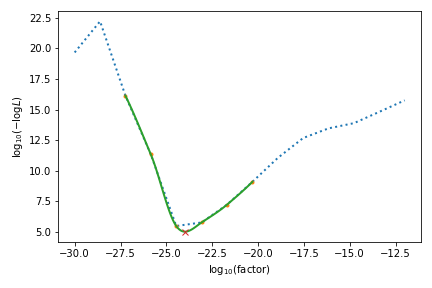

In [88]:
# Determine which factors to tests.
factors = np.logspace(-30, -12, 14)

# Noise estimate to weigh the pixels.
# Poisson noise + background noise.
sig = np.sqrt(data + bkgd_noise**2)

# Tests all these factors.
tests = extract.get_tikho_tests(factors, data=data, sig=sig)  # TODO sig is the uncertainty on the date here so it might be good to call it that?

# Find the best factor.
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

Testing factors...
20/20


<IPython.core.display.Javascript object>


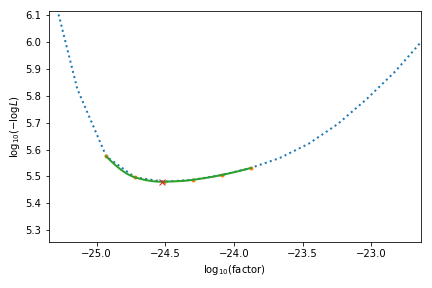

In [89]:
# Refine the grid (span 4 orders of magnitude).
best_fac = np.log10(best_fac)
factors = np.logspace(best_fac-2, best_fac+2, 20)

# No need to specify `data` and `sig` again. 
# TODO: why not? Wouldn't it be better to require that to avoid confusion?
# Answer: When a reference file or science file is specified, the class keeps it
#         as an attribute. When an extraction is called, it is updated if specified.
#         It is done to save some text when iterating on the spatial profile, for
#         example, and to save time (some matrix multiplications don't need to be 
#         re-computed). But I'm open to discuss it!
tests = extract.get_tikho_tests(factors, data=data, sig=sig)
best_fac = extract.best_tikho_factor(tests=tests, i_plot=True)

### Compare result to injected spectrum

In [17]:
simu

{'grid': array([0.55028933, 0.5503206 , 0.55035187, ..., 2.99896924, 2.99903714,
        2.99910505]),
 'f_k': array([4.72029320e+17, 4.71761943e+17, 4.71523937e+17, ...,
        1.55096365e-25, 0.00000000e+00, 0.00000000e+00]),
 'grid_c1': array([0.83615988, 0.83619105, 0.83622223, ..., 2.83632606, 2.83639357,
        2.83646109]),
 'f_c1': array([1.27472109e+17, 1.27455199e+17, 1.27437210e+17, ...,
        2.24931613e+15, 2.24909836e+15, 2.24888048e+15]),
 'grid_c2': array([0.5529112 , 0.55294192, 0.55297263, ..., 1.41168005, 1.4117111 ,
        1.41176256]),
 'f_c2': array([4.62719390e+17, 4.62568633e+17, 4.62453207e+17, ...,
        2.77875163e+16, 2.77851944e+16, 2.77813569e+16]),
 'data': array([[  0.73516122, -24.49601748, -19.63026044, ...,  37.75236538,
          24.27287025,  56.56269847],
        [ 38.61935903, -13.92875226, -25.37555599, ...,   4.10439147,
          24.75755763, -34.51611165],
        [ 21.00564298, -16.60390489,  27.02581793, ..., -20.13111073,
           

In [112]:
f_k = extract(data=data, sig=sig, p_list=spat_pros, tikhonov=True, factor=best_fac)
# f_k = extract(data=data, sig=sig, p_list=spat_pros)

In [91]:
rebuilt = extract.rebuild(f_k)

In [23]:
%matplotlib notebook

In [31]:
plt.plot?

<IPython.core.display.Javascript object>


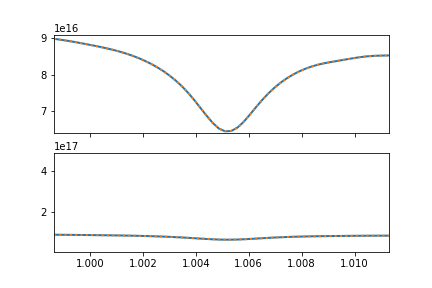

In [27]:
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(extract.lam_grid_c(0), extract.c_list[0].dot(f_k))
ax[0].plot('grid_c1', 'f_c1', ":", data=simu)

ax[1].plot(extract.lam_grid_c(1), extract.c_list[1].dot(f_k))
ax[1].plot('grid_c2', 'f_c2', ":", data=simu)

In [45]:
plt.pcolormesh?

In [66]:
from scipy.interpolate import interp1d

In [72]:
extract.bin_to_pixel?

<IPython.core.display.Javascript object>


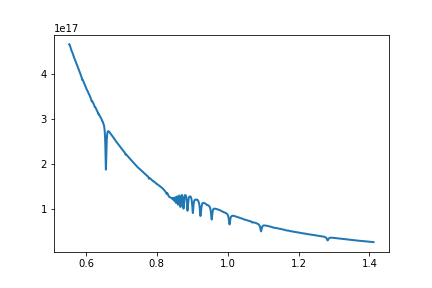

In [17]:
# plt.plot(extract.lam_grid_c(1), extract.c_list[1].dot(f_k))
plt.plot(simu['grid_c2'], simu['f_c2'])

<IPython.core.display.Javascript object>


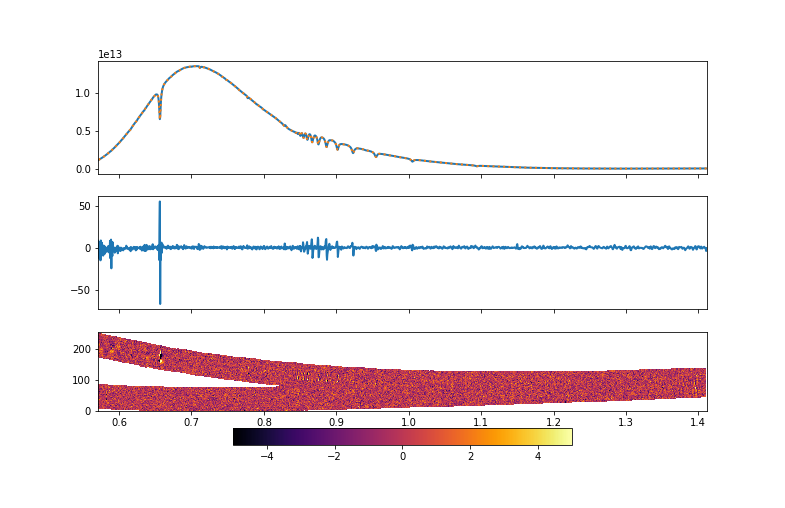

In [92]:
fig, ax = plt.subplots(3, 1, sharex=True)

grid_bin, f_bin = extract.bin_to_pixel(f_k_c=extract.c_list[1].dot(f_k),
                                       grid_pix=wave_maps[1][100,:1800],
                                       grid_f_k=extract.lam_grid_c(1), i_ord=1)
_, f_bin_th = extract.bin_to_pixel(f_k_c=simu['f_c2'], grid_pix=grid_bin, grid_f_k=simu['grid_c2'], i_ord=1)

ax[0].plot(grid_bin, f_bin)
ax[0].plot(grid_bin, f_bin_th, ":")

# f_th_interp = interp1d(simu['grid_c2'], simu['f_c2'], kind='cubic', bounds_error=False, fill_value=np.nan)
ax[1].plot(grid_bin, (f_bin-f_bin_th)/f_bin_th*1e6)

im = ax[-1].pcolormesh(wave_maps[1][100,:1800], np.arange(256), ((rebuilt-data)/sig)[:, :1800], vmin=-5, vmax=5)
# plt.imshow((rebuilt-data)/sig, vmin=-5, vmax=5., interpolation=None)
plt.colorbar(im, ax=ax[-1], orientation="horizontal")

<IPython.core.display.Javascript object>


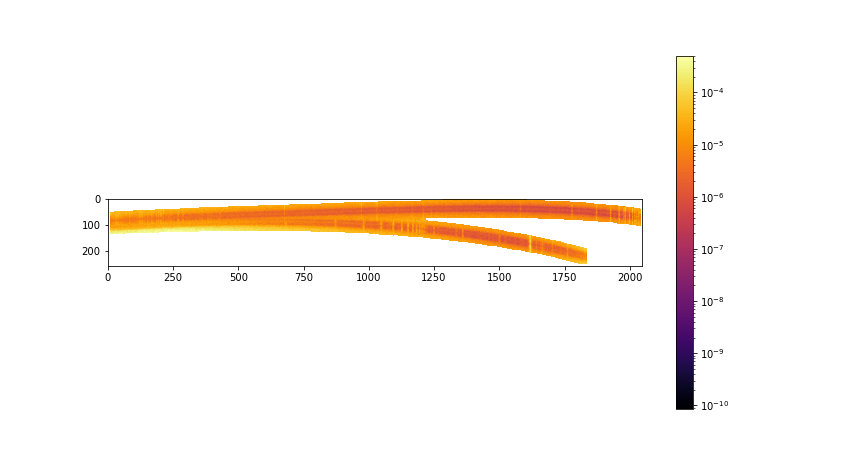

In [29]:
plt.figure()
plt.imshow(np.abs(rebuilt-data)/data, vmax=0.5e-3, norm=LogNorm(), interpolation=None)
plt.colorbar()

### Optimize the spatial profiles

In [37]:
import time

In [110]:
def optimize_profile(self, f_k=None, min_val=1e-3, rtol_map=None,
                     scale_factor=0.1, max_iter=50, n_sample=10, max_sample=20, **kwargs):
    
    # Use object error map to generate a relative
    # error map if `rtol_map` not given
    if rtol_map is None:
        rtol_map = 3 * self.sig / self.data
        
    # extract f_k if not given
    if f_k is None:
        f_k = self(**kwargs)
    
    # Get spatial profiles from object
    p_list = np.array(self.p_list)
    # Save total spatial profile for each column.
    # It should be ~equal to 1, unless the trace goes
    # out of the detector.
    p_tot = np.nansum(p_list, axis=1)
    
    # Iterate
    p_save = []
    # Masked pixels are considered converged
    # TODO: use real mask, deal with normalisation and masks.
    mask = np.array(self.mask_ord)
    pix_converged = np.isnan(p_list)
    p_sum = np.zeros(p_list.shape, dtype=float)
    n_p_sum = np.zeros(p_list.shape, dtype=int)
    converged = False
    i_sample = 0
    
    fig = plt.figure(figsize=(12,12))
    N = 6
    cycler = plt.cycler("color", plt.cm.viridis(np.linspace(0,1,N)))
    colors = cycler.by_key()['color']
    
    i_col_plot = 800
    plt.plot((rtol_map*p_list[0])[50:130, i_col_plot], "k--", alpha=0.4)
    plt.plot((rtol_map*p_list[1])[50:130, i_col_plot], "k", alpha=0.4)
    
    for i in range(max_iter):
        # Get relative error
        rel_err = get_rel_err(self, f_k)

        # Weigh the error depending on the order contribution at each pixel
        # The result is the absolute (not relative) error for each orders
        p_error = rel_err * p_list
        
        # Test convergence
        # Define criterion
        denominator = np.clip(np.abs(p_list), min_val, None)
        criterion = (np.abs(p_error) / denominator)
        # Convert to masked array
        criterion = np.ma.masked_invalid(criterion)
        # Update map of converged pixels
        pix_converged[criterion < rtol_map] = True
        # Check global convergence
        if converged or pix_converged.all():
            # State convergence
            converged = True
            # Make `n_sample` iteration after convergence
            i_sample += 1
            print("Converged.", i_sample, "/", n_sample)
        else:
            print(i, ", mean rel errors: ", criterion[0].mean(), criterion[1].mean(),
                  ", not converged: ", (~pix_converged)[0].sum(), (~pix_converged)[1].sum())        
        
        # Correct p_list with scaled correction
        p_list = p_list + p_error * scale_factor
        
        # Enforce normalization
        norm = np.divide(np.nansum(p_list, axis=1), p_tot,
                         out=np.zeros_like(p_tot), where=p_tot!=0)[:, None, :]
        p_list = np.divide(p_list, norm, out=np.zeros_like(p_list), where=norm!=0)
        
        # Save value of converged pixels to make stats
        if pix_converged.any():
            p_to_save = np.ones_like(p_list) * np.nan
#             p_to_save[pix_converged] = p_list[pix_converged]
            p_to_save[~mask] = p_list.copy()[~mask]
            # Make sure p_save does not exceed `max_sample`
            p_save = p_save[-(max_sample - 1):]
            # Append
            p_save.append(p_to_save)
            
            
#             # Take mean for converged pixels
#             p_sum[pix_converged] += p_list[pix_converged]
#             n_p_sum[pix_converged] += 1
#             p_list[pix_converged] = p_sum[pix_converged]
#             p_list[pix_converged] /= n_p_sum[pix_converged]
#             if (n_p_sum[pix_converged] <= 0).any():
#                 print('weird')
            
            
        # Plot a slice of the spatial profile
        plt.plot(p_error[0, 50:130, i_col_plot], color=colors[i%N], linestyle="--")
        plt.plot(p_error[1, 50:130, i_col_plot], color=colors[i%N])
        fig.canvas.draw()
        time.sleep(1)

        # Stop when `n_sample` iteration after convergence
        if i_sample == n_sample:
            break
            
        # Re-extract
        f_k = self(p_list=p_list, **kwargs)

    else:
        print("*** Not converged: Reached max iteration ***")
        
    plt.show()
    return np.array(p_save)
    
def get_rel_err(self, f_k):
    """
    Return the relative error of the rebuilt detector image.
    """
    # Define an error map
    rebuilt = self.rebuild(f_k)
    rel_err = (self.data - rebuilt) / rebuilt

    return rel_err


<IPython.core.display.Javascript object>


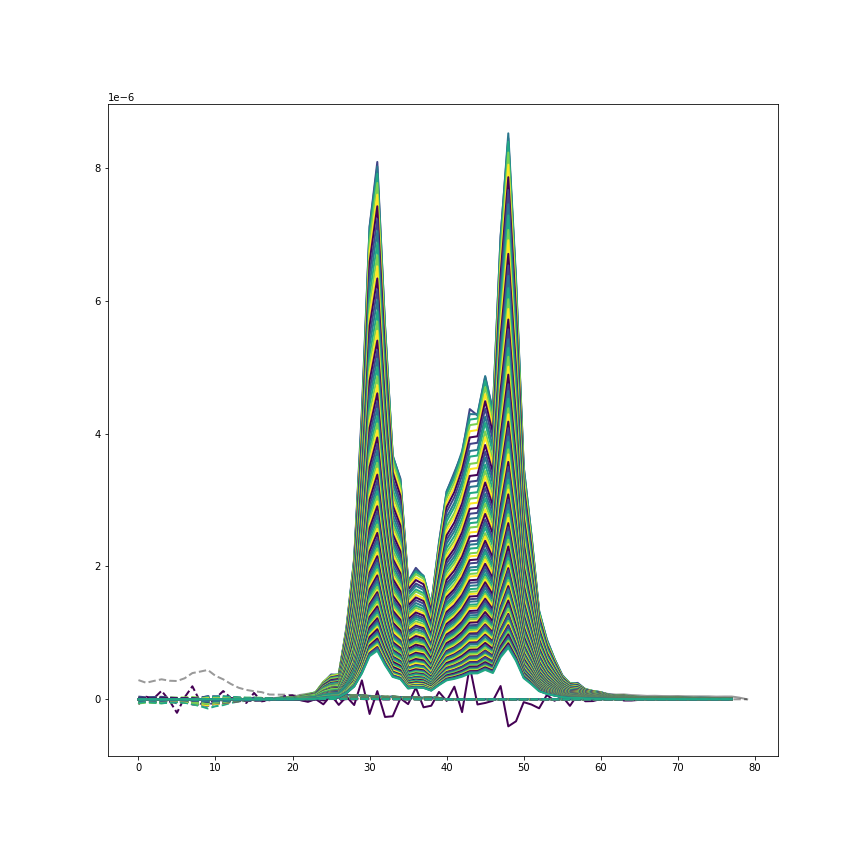

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


0 , mean rel errors:  3.7893912216643973e-06 7.760315268379007e-06 , not converged:  281814 282056


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


1 , mean rel errors:  6.439793098163864e-06 0.00032582443018316107 , not converged:  281536 281658


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


2 , mean rel errors:  5.235370467097278e-06 0.00010512750829891294 , not converged:  281528 281505


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


3 , mean rel errors:  4.689412533746105e-06 4.476711948847823e-05 , not converged:  281522 281491


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


4 , mean rel errors:  4.378510939244247e-06 2.7968532219987463e-05 , not converged:  281521 281485


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


5 , mean rel errors:  4.1887744524263164e-06 2.502920636579353e-05 , not converged:  281518 281479


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


6 , mean rel errors:  4.0821432626813515e-06 2.356742828888577e-05 , not converged:  281516 281475


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


7 , mean rel errors:  3.9069442648485655e-06 2.2429651863361634e-05 , not converged:  281513 281469


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


8 , mean rel errors:  3.8108336675712583e-06 2.1641406234019627e-05 , not converged:  281513 281468


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


9 , mean rel errors:  3.7548413935057936e-06 2.1059580088904567e-05 , not converged:  281509 281465


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


10 , mean rel errors:  3.6298343330151304e-06 2.064686242213487e-05 , not converged:  281508 281464


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


11 , mean rel errors:  3.6158026493202627e-06 2.0408513820218437e-05 , not converged:  281508 281464


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


12 , mean rel errors:  3.505908711588174e-06 2.0212174320531665e-05 , not converged:  281508 281462


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


13 , mean rel errors:  3.4019251181587643e-06 2.0030118054841327e-05 , not converged:  281508 281461


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


14 , mean rel errors:  3.334429543315969e-06 1.9974367133444684e-05 , not converged:  281507 281460


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


15 , mean rel errors:  3.313145563744693e-06 2.002949621047179e-05 , not converged:  281507 281452


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


16 , mean rel errors:  3.2981877720976965e-06 2.0122043200978685e-05 , not converged:  281506 281443


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


17 , mean rel errors:  3.234396734152521e-06 2.0220224976056345e-05 , not converged:  281505 281440


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


18 , mean rel errors:  3.2412070650973716e-06 2.0405203937555478e-05 , not converged:  281505 281439


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


19 , mean rel errors:  3.122243092543812e-06 2.0656000981366244e-05 , not converged:  281505 281436


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


20 , mean rel errors:  3.076654412439997e-06 2.1016966268978036e-05 , not converged:  281505 281435


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


21 , mean rel errors:  3.1559253325114865e-06 2.1532116039888066e-05 , not converged:  281505 281435


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


22 , mean rel errors:  3.0217187369053347e-06 2.202625561709197e-05 , not converged:  281505 281434


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


23 , mean rel errors:  3.01554454959646e-06 2.2839640127422432e-05 , not converged:  281503 281432


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


24 , mean rel errors:  2.912822236400307e-06 2.39419204219971e-05 , not converged:  281503 281432


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


25 , mean rel errors:  3.02078727414692e-06 2.5569496142411292e-05 , not converged:  281502 281431


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


26 , mean rel errors:  2.9149383547028944e-06 2.7605146905137754e-05 , not converged:  281501 281430


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


27 , mean rel errors:  2.8962099369725916e-06 3.0243015371586608e-05 , not converged:  281501 281430


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


28 , mean rel errors:  2.8983331818196994e-06 3.299878760788765e-05 , not converged:  281501 281429


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


29 , mean rel errors:  2.8891290454808778e-06 3.4615289242637565e-05 , not converged:  281501 281429


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


30 , mean rel errors:  2.847486166143877e-06 3.3376816773147116e-05 , not converged:  281501 281429


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


31 , mean rel errors:  2.7699744415464274e-06 2.954028941549017e-05 , not converged:  281501 281426


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


32 , mean rel errors:  2.798511326005666e-06 2.4982509819478882e-05 , not converged:  281500 281421


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


33 , mean rel errors:  2.871415441004646e-06 2.0985201205841064e-05 , not converged:  281500 281418


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


34 , mean rel errors:  2.785843528079371e-06 1.7852091587590405e-05 , not converged:  281500 281417


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


35 , mean rel errors:  2.738002802497926e-06 1.5605065550398707e-05 , not converged:  281500 281417


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


36 , mean rel errors:  2.703208914488634e-06 1.3989980648285941e-05 , not converged:  281500 281417


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


37 , mean rel errors:  2.727509886379887e-06 1.285437787179687e-05 , not converged:  281500 281417


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


38 , mean rel errors:  2.7539523379532907e-06 1.2039023503359194e-05 , not converged:  281500 281417


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


39 , mean rel errors:  2.6576210611826447e-06 1.1371166274034416e-05 , not converged:  281500 281417


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


40 , mean rel errors:  2.7709743938839153e-06 1.0964056244849861e-05 , not converged:  281500 281416


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


41 , mean rel errors:  2.612116547498106e-06 1.0537118242523199e-05 , not converged:  281500 281415


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


42 , mean rel errors:  2.654333699435105e-06 1.0265015632088913e-05 , not converged:  281500 281415


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


43 , mean rel errors:  2.6859392309011437e-06 1.006926479661394e-05 , not converged:  281499 281414


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


44 , mean rel errors:  2.680618992039287e-06 9.893391903064136e-06 , not converged:  281499 281412


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


45 , mean rel errors:  2.570970003531331e-06 9.695687926831246e-06 , not converged:  281499 281410


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


46 , mean rel errors:  2.5771433427945734e-06 9.565138482029113e-06 , not converged:  281499 281404


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


47 , mean rel errors:  2.593499095473122e-06 9.463280298669096e-06 , not converged:  281499 281398


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


48 , mean rel errors:  2.5476304832545924e-06 9.365275716348974e-06 , not converged:  281499 281395


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


49 , mean rel errors:  2.5846598177613634e-06 9.30607150432586e-06 , not converged:  281499 281394


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


50 , mean rel errors:  2.534913563483758e-06 9.210895455468386e-06 , not converged:  281499 281388


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


51 , mean rel errors:  2.478241057424228e-06 9.117482768430852e-06 , not converged:  281499 281385


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


52 , mean rel errors:  2.478265163072824e-06 9.049266404929435e-06 , not converged:  281498 281383


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


53 , mean rel errors:  2.5126898717971426e-06 9.031910130141013e-06 , not converged:  281498 281383


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


54 , mean rel errors:  2.5427783112550177e-06 8.989158974377766e-06 , not converged:  281498 281383


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


55 , mean rel errors:  2.490847566500764e-06 8.93072980653781e-06 , not converged:  281498 281382


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


56 , mean rel errors:  2.546099452525181e-06 8.902060016123463e-06 , not converged:  281498 281382


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


57 , mean rel errors:  2.453905770370926e-06 8.812932431702568e-06 , not converged:  281498 281382


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


58 , mean rel errors:  2.508929829417187e-06 8.798214349086306e-06 , not converged:  281498 281382


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


59 , mean rel errors:  2.4585124474418808e-06 8.7343018459339e-06 , not converged:  281498 281382


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


60 , mean rel errors:  2.471507192479916e-06 8.696121975432871e-06 , not converged:  281498 281382


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


61 , mean rel errors:  2.509051662367207e-06 8.671537013136969e-06 , not converged:  281498 281381


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


62 , mean rel errors:  2.390933211213944e-06 8.577910206229948e-06 , not converged:  281498 281381


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


63 , mean rel errors:  2.438551411563236e-06 8.554600091218605e-06 , not converged:  281498 281381


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


64 , mean rel errors:  2.396242825437266e-06 8.500789161398577e-06 , not converged:  281498 281381


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


65 , mean rel errors:  2.398410603104678e-06 8.473656891922464e-06 , not converged:  281498 281381


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


66 , mean rel errors:  2.4176313762487294e-06 8.45070957954873e-06 , not converged:  281497 281380


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


67 , mean rel errors:  2.4959593827178115e-06 8.453877926956016e-06 , not converged:  281497 281380


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


68 , mean rel errors:  2.3673637063289087e-06 8.346187566407255e-06 , not converged:  281497 281380


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


69 , mean rel errors:  2.3831529426378544e-06 8.310515971404425e-06 , not converged:  281496 281380


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


70 , mean rel errors:  2.4360120422171825e-06 8.311116557633334e-06 , not converged:  281496 281379


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


71 , mean rel errors:  2.3308299044577292e-06 8.234915188655727e-06 , not converged:  281495 281379


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


72 , mean rel errors:  2.346713065393101e-06 8.191626653356134e-06 , not converged:  281495 281379


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


73 , mean rel errors:  2.3292509970305854e-06 8.146283275994433e-06 , not converged:  281495 281378


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


74 , mean rel errors:  2.285137936492373e-06 8.099666131601065e-06 , not converged:  281495 281378


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


75 , mean rel errors:  2.368257892923123e-06 8.113501725986312e-06 , not converged:  281495 281378


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


76 , mean rel errors:  2.280811183890765e-06 8.04600175987081e-06 , not converged:  281495 281378


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


77 , mean rel errors:  2.302158051779729e-06 8.029923944468081e-06 , not converged:  281495 281378


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


78 , mean rel errors:  2.2981243781615916e-06 7.991793515803882e-06 , not converged:  281494 281377


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


79 , mean rel errors:  2.3942113072840507e-06 8.011685332185153e-06 , not converged:  281494 281376


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


80 , mean rel errors:  2.3095545757160757e-06 7.938947786519754e-06 , not converged:  281493 281376


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


81 , mean rel errors:  2.3043875623049733e-06 7.902915549547047e-06 , not converged:  281493 281376


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


82 , mean rel errors:  2.3147473554854934e-06 7.88626013136412e-06 , not converged:  281493 281376


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


83 , mean rel errors:  2.2964414570683353e-06 7.847580761125854e-06 , not converged:  281493 281376


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


84 , mean rel errors:  2.2406387213114446e-06 7.786214376999081e-06 , not converged:  281491 281376


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


85 , mean rel errors:  2.315064757683776e-06 7.798987463611626e-06 , not converged:  281491 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


86 , mean rel errors:  2.3244230843985337e-06 7.77804081547729e-06 , not converged:  281490 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


87 , mean rel errors:  2.2134083310667734e-06 7.692289982660509e-06 , not converged:  281490 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


88 , mean rel errors:  2.3298053037334585e-06 7.738877474181604e-06 , not converged:  281490 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


89 , mean rel errors:  2.2157527004824623e-06 7.644748399507582e-06 , not converged:  281489 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


90 , mean rel errors:  2.1746842707168736e-06 7.599614487468317e-06 , not converged:  281489 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


91 , mean rel errors:  2.324254057810474e-06 7.666994025960496e-06 , not converged:  281488 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


92 , mean rel errors:  2.3244424253681825e-06 7.62824492535525e-06 , not converged:  281487 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


93 , mean rel errors:  2.2158101971097544e-06 7.543347318976597e-06 , not converged:  281487 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


94 , mean rel errors:  2.222891122855568e-06 7.509568627345105e-06 , not converged:  281486 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


95 , mean rel errors:  2.1333898684723673e-06 7.443038592400058e-06 , not converged:  281484 281375


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


96 , mean rel errors:  2.1592568968611222e-06 7.427296053669073e-06 , not converged:  281484 281374


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


97 , mean rel errors:  2.2393156969020766e-06 7.45751257659572e-06 , not converged:  281482 281374


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


98 , mean rel errors:  2.2005312978601373e-06 7.412857057416321e-06 , not converged:  281482 281374


/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in less


99 , mean rel errors:  2.1473518439148132e-06 7.3590362777816e-06 , not converged:  281481 281374
*** Not converged: Reached max iteration ***


In [113]:
spat_pros_estimates = optimize_profile(extract, f_k=f_k, tikhonov=True,
                                       factor=best_fac, scale_factor=0.8, max_iter=100)

In [114]:
plt.close()

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


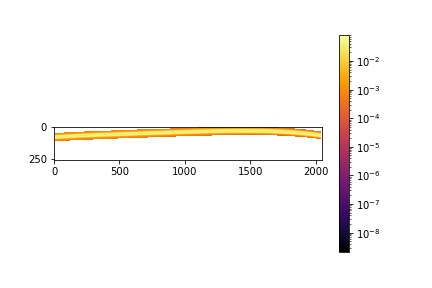

In [95]:
plt.imshow(np.nanmean(spat_pros_estimates, axis=0)[0], norm=LogNorm())
plt.colorbar()

<IPython.core.display.Javascript object>


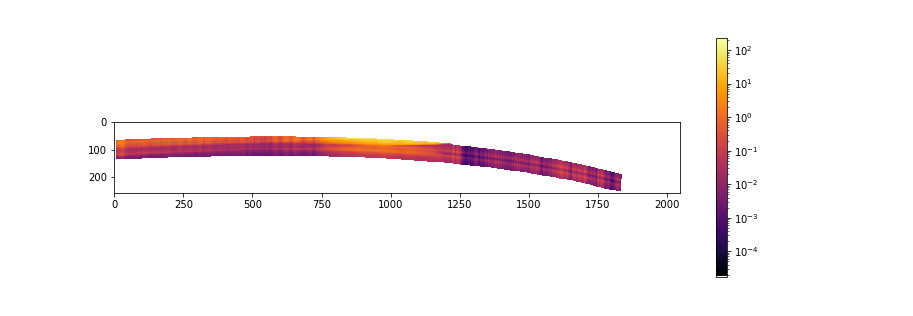

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [65]:
plt.figure()
plt.imshow((np.nanstd(spat_pros_estimates, axis=0)[1]/np.nanmean(spat_pros_estimates, axis=0)[1]/sig*data), norm=LogNorm())
plt.colorbar()

In [122]:
spat_pro_mean = np.nanmean(spat_pros_estimates, axis=0)
# spat_pro_mean[~np.isfinite(spat_pro_mean)] = 0

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


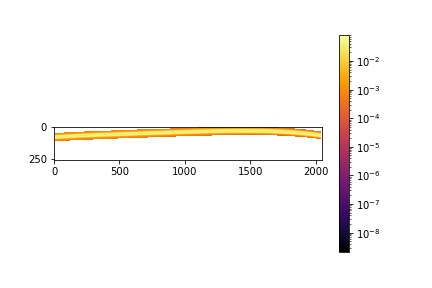

In [127]:
# plt.imshow(((spat_pro_mean-np.array(spat_pros))/spat_pro_mean)[0])
plt.imshow(spat_pro_mean[0], norm=LogNorm())
plt.colorbar()

In [128]:
f_k = extract(data=data, sig=sig, tikhonov=True, factor=best_fac, p_list=spat_pro_mean)
# f_k = extract(data=data, sig=sig)

In [129]:
rebuilt = extract.rebuild(f_k)
rel_err = (extract.data - rebuilt) / rebuilt

<IPython.core.display.Javascript object>


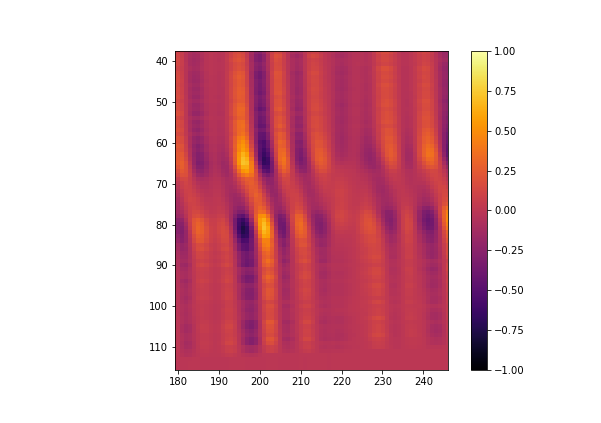

In [131]:
plt.figure()
plt.imshow((rebuilt-data)/sig, vmin=-1, vmax=1, interpolation=None)
plt.colorbar()

<IPython.core.display.Javascript object>


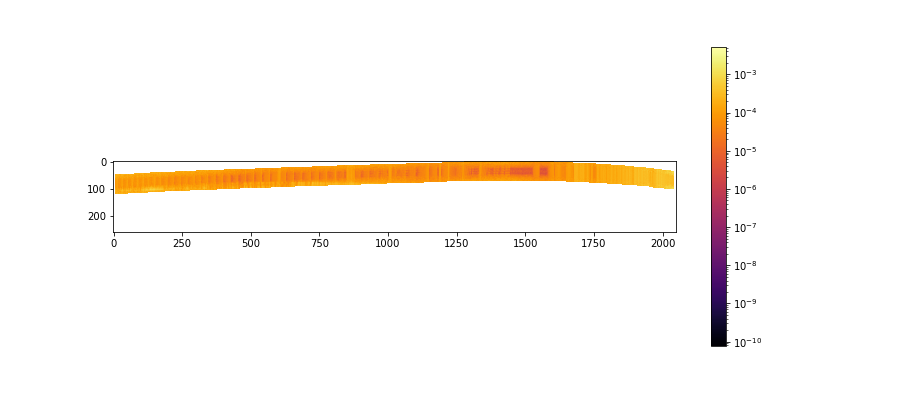

/Users/antoinedb/anaconda3/envs/extraction/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [133]:
plt.figure()
plt.imshow(np.abs(spat_pros[0]-extract.p_list[0])/spat_pros[0], norm=LogNorm())
plt.colorbar()

<IPython.core.display.Javascript object>


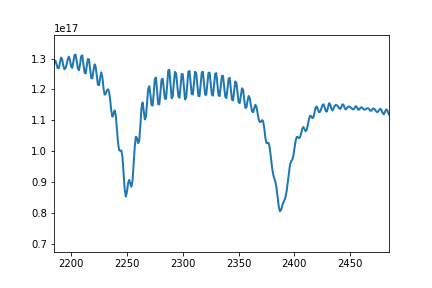

In [132]:
plt.plot(f_k)

<IPython.core.display.Javascript object>


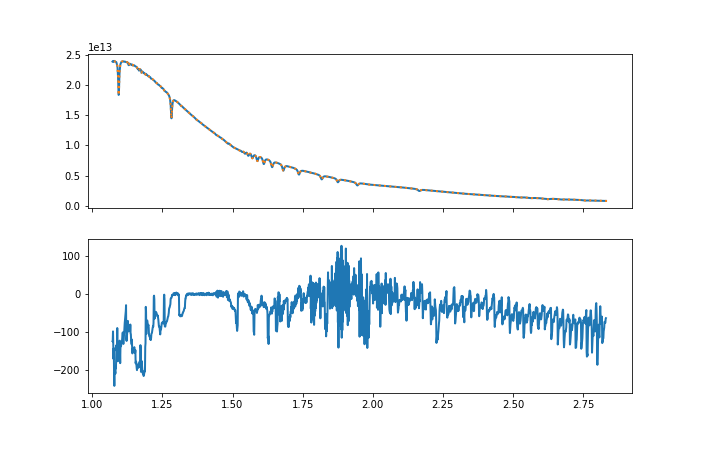

In [133]:
fig, ax = plt.subplots(2, 1, sharex=True)
i_ord = 0

grid_bin, f_bin = extract.bin_to_pixel(f_k_c=extract.c_list[i_ord].dot(f_k),
                                       grid_pix=wave_maps[i_ord][100,:1800],
                                       grid_f_k=extract.lam_grid_c(i_ord), i_ord=i_ord)
_, f_bin_th = extract.bin_to_pixel(f_k_c=simu[f'f_c{i_ord+1}'], 
                                   grid_pix=grid_bin, grid_f_k=simu[f'grid_c{i_ord+1}'], i_ord=i_ord)

ax[0].plot(grid_bin, f_bin)
ax[0].plot(grid_bin, f_bin_th, ":")

# f_th_interp = interp1d(simu['grid_c2'], simu['f_c2'], kind='cubic', bounds_error=False, fill_value=np.nan)
ax[1].plot(grid_bin, (f_bin-f_bin_th)/f_bin_th*1e6)

# im = ax[-1].pcolormesh(wave_maps[1][100,:1800], np.arange(256), ((rebuilt-data)/sig)[:, :1800], vmin=-5, vmax=5)
# # plt.imshow((rebuilt-data)/sig, vmin=-5, vmax=5., interpolation=None)
# plt.colorbar(im, ax=ax[-1], orientation="horizontal")

In [53]:
plt.close()